# Predicting most Efficient Interventions for Life Span Increase
#### Data Literacy at University of Tübingen, Winter 2023/24

---
&copy; Daniel Flat, Jackson Harmon, Eric Nazarenus, Aline Bittler 2023. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

Template by Philipp Hennig, 2023. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

In [114]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dataclasses import dataclass
from scipy.optimize import curve_fit

In [115]:
# Group Constants
MALE = 'male'
FEMALE = 'female'
SEX_CATEGORIES = [MALE, FEMALE]

# Intervention Constants
CONTROL_GROUP = 'None'
ALL_GROUP = 'All'
ONE_REMOVED_PREFIX = 'no_'

# Dataset Contsants
DATASET_DIRECTORY = os.path.join('..', 'dat', 'RMR_data')

# Graphing constants
COLOR_MAP = ["#ADD8E6", "#008000", "#FFD700", "#800080", "#FF7F50", "#40E0D0", "#708090", "#FF8C00", "#FF00FF", "#008080"]

In [116]:
dataset_paths = os.listdir(DATASET_DIRECTORY)

def convert_filename_to_key(filename, category):
    category_removed = filename[len(category) + 1:]
    return os.path.splitext(category_removed)[0]

def create_dataset_mapping(dataset_directory, categories):
    dataset_mappings = {}
    
    for category in categories:
        category_path = {} 
        for path in dataset_paths:
            full_path = os.path.join(dataset_directory, path)
    
            if category == path[:len(category)]:
                key = convert_filename_to_key(path, category)
                category_path[key] = full_path
        dataset_mappings[category] = category_path
    
    return dataset_mappings

In [117]:
def is_one_removed_intervention(key):
    if len(key) < 3:
        return False

    return key[:len(ONE_REMOVED_PREFIX)] == ONE_REMOVED_PREFIX

def extract_single_interventions(dataset_mapping: dict):
    single_interventions = []
    for key in dataset_mapping.keys():
        if key == ALL_GROUP:
            continue
        elif key == CONTROL_GROUP:
            continue
        elif is_one_removed_intervention(key):
            continue
        else:
            single_interventions.append(key)
    
    return single_interventions

def create_one_removed_key(key: str, intervention_list: []) -> []:
    removed_key = key[len(ONE_REMOVED_PREFIX):]

    removed_intervention_list = []
    for intervention in intervention_list:
        if intervention != removed_key:
            removed_intervention_list.append(intervention)

    return removed_intervention_list

def create_intervention_list_from_group(key: str, intervention_list: []):
    new_intervention_list = None
    
    if key == ALL_GROUP:
        new_intervention_list = intervention_list
    elif key == CONTROL_GROUP:
        new_intervention_list = []
    elif is_one_removed_intervention(key):
        new_intervention_list = create_one_removed_key(key, intervention_list)
    else:
        new_intervention_list = [key]

    return ','.join(new_intervention_list)

In [118]:
def load_csv(path):
    return pd.read_csv(
                        path,
                        skiprows=0,
                        sep=',',
                        engine='python',
                        decimal='.',
                        dtype={'x': 'float64', 'y': 'float64'}
            )


def create_dataset_by_category(category_path: dict, single_interventions: []):
    datasets = {}
    for key, path in category_path.items():
        new_key = create_intervention_list_from_group(key, single_interventions)
        datasets[new_key] = load_csv(path)
    return datasets

dataset_mapping = create_dataset_mapping(DATASET_DIRECTORY, SEX_CATEGORIES)
female_dataset_paths = dataset_mapping[FEMALE]
female_single_interventions = extract_single_interventions(female_dataset_paths)

female_dataset = create_dataset_by_category(female_dataset_paths, female_single_interventions)

In [148]:
def gompertz(x, alpha, beta):
    return alpha * np.exp(beta * x)

@dataclass
class GompertzParameters:
    alpha: np.float64
    beta: np.float64

    @staticmethod
    def from_sequence(seq):
        return GompertzParameters(alpha=seq[0], beta=seq[1])

    def to_tuple(self):
        return (self.alpha, self.beta)

    def __str__(self) -> str:
        return f'(alpha={self.alpha:.4f}, beta={self.beta:.4f})'

    def __repr__(self) -> str:
        return f'(alpha={self.alpha:.4f}, beta={self.beta:.4f})'


DEFAULT_INITIAL_PARAMETERS = GompertzParameters(alpha=0.1, beta=0.085)

def fit_gompertz_model(ages: pd.DataFrame,
                       mortality_rate: pd.DataFrame,
                       initial_parameters: GompertzParameters = DEFAULT_INITIAL_PARAMETERS,
                       max_fit_iterations: int = 2_500) -> GompertzParameters:
    p0 = initial_parameters.to_tuple()
    predicted_parameters, covariance = curve_fit(gompertz, ages, mortality_rate, p0=p0, maxfev=max_fit_iterations)
    return GompertzParameters.from_sequence(predicted_parameters)

test_dataset = female_dataset['HSCs']

def calculate_ages(dataset):
    return np.array(dataset.x) / 365 # ages in years

def calculate_mortality_rate(dataset):
    return np.array(1 - dataset.y)

def fit(dataset):
    ages = calculate_ages(dataset)
    mortality_rate = calculate_mortality_rate(dataset)
    
    predicted_parameters = fit_gompertz_model(ages, mortality_rate)
    predicted_mortality = gompertz(ages, predicted_parameters.alpha, predicted_parameters.beta)
    return predicted_mortality

In [149]:
def plot_fitted_gompertz_curve(ages, mortality_rate, all_mortality_rate, single_mortality_rate, title: str) -> None:
    plt.scatter(ages, mortality_rate, label='Observed Data', color=COLOR_MAP[0])
    plt.plot(ages, predicted_mortality, label='All Gompertz Fit', color=COLOR_MAP[1])
    plt.plot(ages, single_mortality_rate, label='Single Gompertz Fit', color=COLOR_MAP[2])
    plt.xlabel('Age of Mice (Years)')
    plt.ylabel(f'Mortality Rate ({title})')
    plt.legend()
    plt.show()

In [ ]:
tests = [
    ['Gal-Nav,mTERT,Rapamycin', ['Gal-Nav', 'mTERT', 'Rapamycin']],
    ['HSCs,Gal-Nav,Rapamycin', ['HSCs', 'Gal-Nav', 'Rapamycin']],
    ['HSCs,mTERT,Rapamycin', ['HSCs', 'mTERT', 'Rapamycin']],
    ['HSCs,Gal-Nav,mTERT', ['HSCs', 'Gal-Nav', 'mTERT']]
]

### Additive Model (wrt output)
We begin with one of the most simple tests possible. We make the assumption that single interventions are additive. That is, the mortality curve of three interventions should be the same as the individual mortality curves of the three interventions added together. We can clearly see below that this is not the case. Namely, the adding of the single models overestimates the mortality curve every time.

After further thinking this is clear for two reasons. The first is that the mortality rate as time goes to infinity should reach one, however with adding the curves it will approach 3 instead, which does not make sense. Secondly, it is perfectly possible that multiple interventions could either influence each other negatively or target the same mechanism, thereby explaining the sub-linear properties we see.

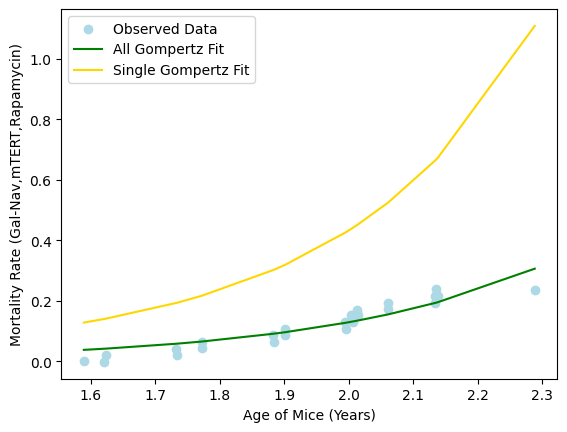

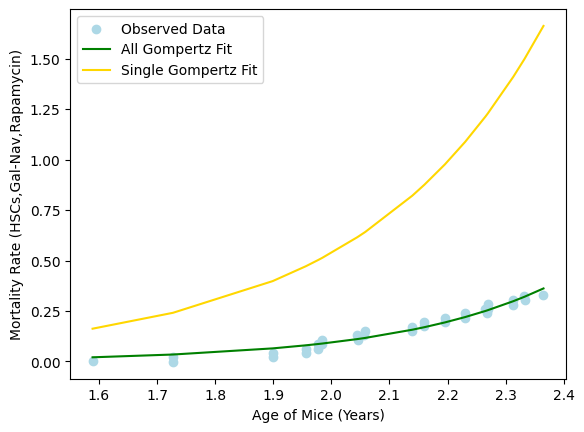

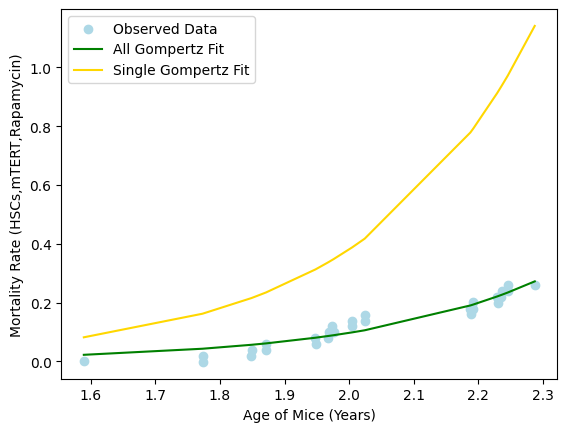

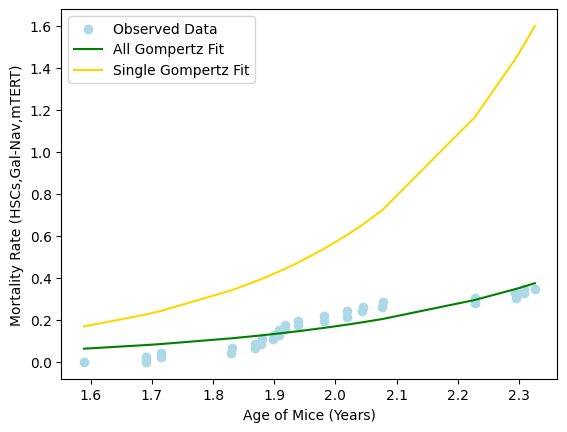

In [184]:
for keys in tests:
    all_key, single_keys = keys

    all_ages = calculate_ages(female_dataset[all_key])
    all_mortality_rate = calculate_mortality_rate(female_dataset[all_key])
    
    predicted_parameters = fit_gompertz_model(all_ages, all_mortality_rate)
    predicted_mortality = gompertz(all_ages, predicted_parameters.alpha, predicted_parameters.beta)
    
    single_predicted_mortality = 0
    for key in single_keys:
        single_ages = calculate_ages(female_dataset[key])
        single_mortality_rate = calculate_mortality_rate(female_dataset[key])
        
        predicted_parameters = fit_gompertz_model(single_ages, single_mortality_rate)
        single_predicted_mortality += gompertz(all_ages, predicted_parameters.alpha, predicted_parameters.beta)

    plot_fitted_gompertz_curve(all_ages, all_mortality_rate, predicted_mortality, single_predicted_mortality, all_key)

### Harmonic Mean of Beta Values

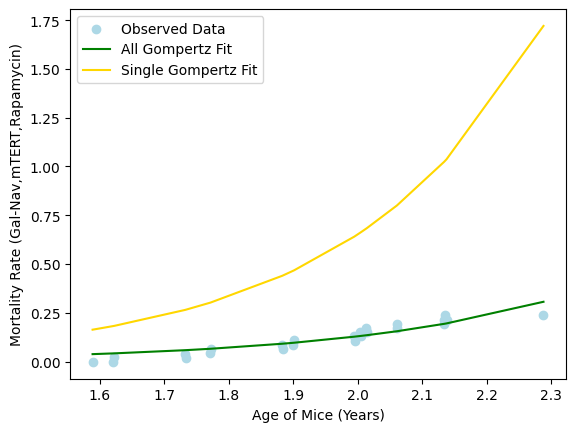

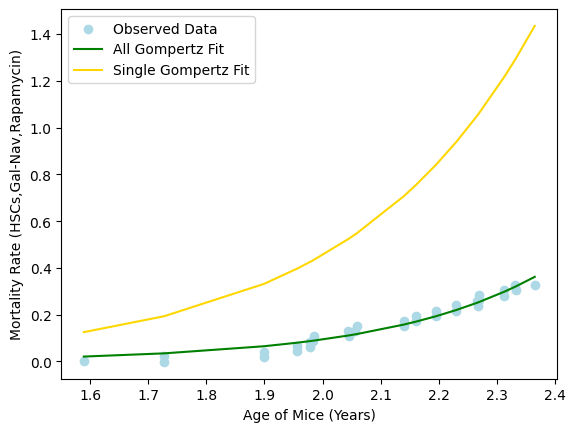

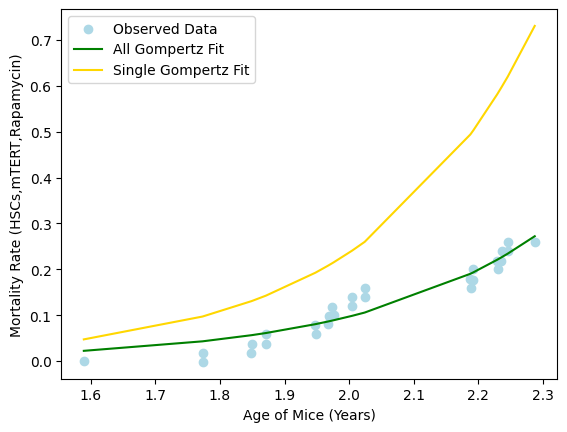

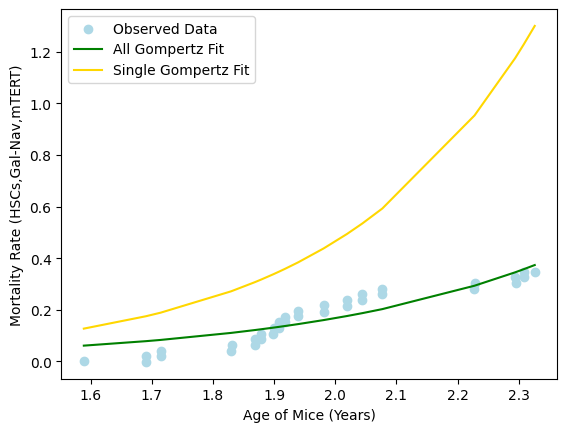

In [185]:
def harmonic_mean(values):
    denominator = []
    for value in values:
        denominator.append(1 / value)
    return len(values) / sum(denominator)

for keys in tests:
    all_key, single_keys = keys

    all_ages = calculate_ages(female_dataset[all_key])
    all_mortality_rate = calculate_mortality_rate(female_dataset[all_key])
    
    predicted_parameters = fit_gompertz_model(all_ages, all_mortality_rate)
    predicted_mortality = gompertz(all_ages, predicted_parameters.alpha, predicted_parameters.beta)
    
    alphas = []
    betas = []
    for key in single_keys:
        single_ages = calculate_ages(female_dataset[key])
        single_mortality_rate = calculate_mortality_rate(female_dataset[key])
        
        predicted_parameters = fit_gompertz_model(single_ages, single_mortality_rate)
        alphas.append(predicted_parameters.alpha)
        betas.append(predicted_parameters.beta)

    alpha = sum(alphas) / len(alphas)
    beta = harmonic_mean(betas)
    single_predicted_mortality = gompertz(all_ages, alpha, beta)
    plot_fitted_gompertz_curve(all_ages, all_mortality_rate, predicted_mortality, single_predicted_mortality, all_key)

### Linear (w.r.t output) Model
As a next step we try to model using only a slightly more complicated model, a linear one. There are multiply ways the model can be linear. We

In [ ]:
# TODO

### Linear (w.r.t parameters) Model
For our second test we attempt two types of linear models. 

In [1]:
# TODO